In [36]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import torch
import cv2
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd.variable import Variable

#####Import the CIFAR-10 data

In [37]:
tf.keras.datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print("X_train shape # {} ".format(X_train.shape),'\n')
print("X_test shape  # {} ".format(X_test.shape),'\n')
print("y_train shape # {} ".format(y_train.shape),'\n')
print("y_test shape  # {} ".format(y_test.shape))

X_train shape # (50000, 32, 32, 3)  

X_test shape  # (10000, 32, 32, 3)  

y_train shape # (50000, 1)  

y_test shape  # (10000, 1) 


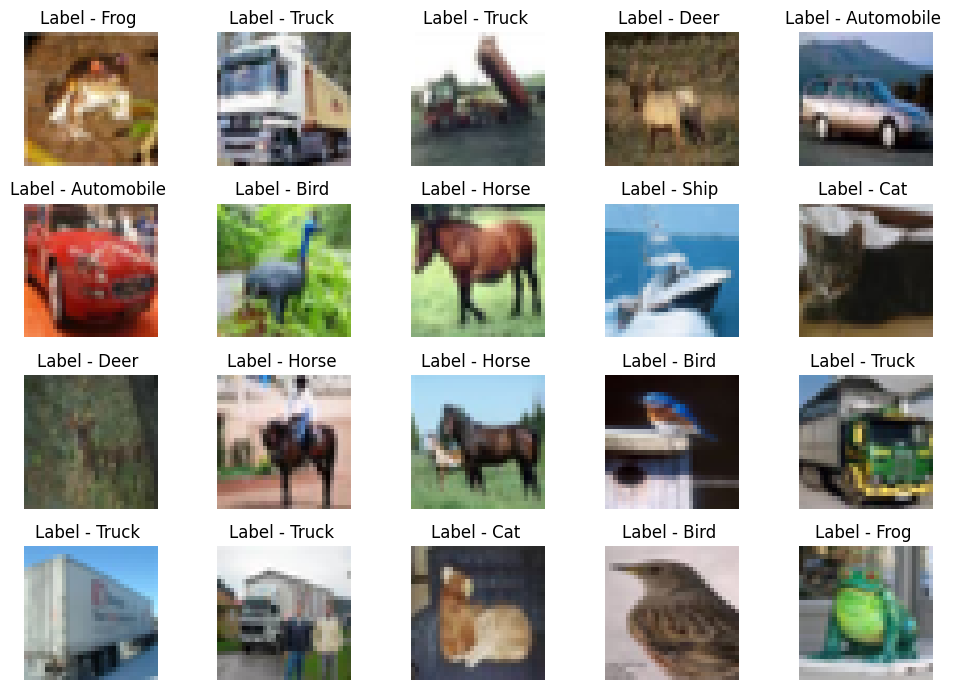

In [38]:
'''
    1. Take the sample of 20 datasets from both train and test
    2. Make a dictionary that would store all the labels with key and value pairs:
        key : key would be the index number and that is unique
        value : value would be the labels
'''
MINIMUM = 0
MAXIMUM = 20
IMAGES  = X_train[MINIMUM : MAXIMUM]
LABELS  = y_train[MINIMUM : MAXIMUM]

object_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

'''
    Plot the images with labels
'''
plt.figure(figsize = (10, 7))
for index, image in enumerate(IMAGES):
  plt.subplot(4, 5, index + 1)
  plt.title('Label - {} '.format(object_dict[LABELS[index][0]].capitalize()))
  plt.imshow(image)
  plt.axis("off")

plt.tight_layout()
plt.show()

In [39]:
'''
    1. Transform the data so that Gradient would stable
'''
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

'''
    1. Initialize the batch size
    2. Download the dataset and create the data loader for further training
'''
BATCH_SIZE = 64
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
DATA_LOADER   = DataLoader(
    train_dataset, batch_size = BATCH_SIZE, shuffle=True
)

Files already downloaded and verified


In [40]:
'''
  Store the total data size into the varibale named SHAPE
'''
SHAPE = []
[SHAPE.append(data.shape[0]) for data, _ in DATA_LOADER]

'''
    Iterate the DATA_LOADER and display the shape of data and labels with batch_size
'''
data, labels = next(iter(DATA_LOADER))

print("Train data shape with batch_size  # {} ".format(data.shape),'\n')
print("Train label shape with batch_size # {} ".format(labels.shape),'\n')
print("Batch size shape # {} ".format(DATA_LOADER.batch_size),'\n')

print("_"*50, '\n')

print("Total data size # {} ".format(sum(SHAPE)).upper())

Train data shape with batch_size  # torch.Size([64, 3, 64, 64])  

Train label shape with batch_size # torch.Size([64])  

Batch size shape # 64  

__________________________________________________ 

TOTAL DATA SIZE # 50000 


#####Define the GPU

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device # {} ".upper().format(device))

DEVICE # cuda 


#####Create Generator model

In [51]:
'''
  This class defines a Generator neural network module.

  The Generator is a key component in Generative Adversarial Networks (GANs) that aims to generate realistic data, such as images, from random noise.

'''
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        '''
          The following lines define two components of the Generator: LATENT_SAMPLE and CONV_TRANSPOSE.

          LATENT_SAMPLE:
            This component consists of fully connected (FC) layers that take random noise as input and transform it into a higher-dimensional representation that can be reshaped into a feature map.
        '''
        self.LATENT_SAMPLE = self.fc_block(input_features = 100, output_features = 8 * 8 * 512)

        '''
          CONV_TRANSPOSE:
            This component is responsible for the main image generation process. It uses transposed convolutional layers (also known as deconvolutional layers) to upsample the feature map generated by LATENT_SAMPLE into a full-sized image.
        '''
        self.CONV_TRANSPOSE = self.conv_block(input_channels=512)

    def fc_block(self, input_features = 100, output_features = 8 * 8 * 512):
        '''
          	This method defines a fully connected (FC) block. It consists of an FC layer followed by a ReLU activation function.
        '''
        return nn.Sequential(
            nn.Linear(in_features = input_features, out_features = output_features),
            nn.ReLU(inplace=True)
        )

    def conv_block(self, input_channels=None):
        '''
            This method defines a convolutional block. It consists of a sequence of transposed convolutional layers, ReLU activation functions, and batch normalization.
        '''
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels = input_channels,\
                               out_channels = 256,\
                               kernel_size = (4, 4),\
                               stride = (2, 2),\
                               padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(in_channels = 256,\
                               out_channels = 128,\
                               kernel_size = (4, 4),\
                               stride = (2, 2),\
                               padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(in_channels = 128,\
                               out_channels = 3,\
                               kernel_size = (4, 4),\
                               stride = (2, 2),\
                               padding = 1),
            nn.Tanh()
        )

    def forward(self, x):
        '''
          The forward method defines the data flow through the Generator.

          It first processes the random noise through the LATENT_SAMPLE component to create a higher-dimensional feature representation.
        '''
        LATENT_SAMPLE = self.LATENT_SAMPLE(x)

        '''
          The feature representation is reshaped into a 4-dimensional tensor to match the expected input shape of the CONV_TRANSPOSE component.
        '''
        LATENT_SAMPLE = LATENT_SAMPLE.view(-1, 512, 8, 8)

        '''
          The feature representation is then passed through the CONV_TRANSPOSE component, which performs the upsampling to generate an image-like tensor.
        '''
        TRANSPOSE = self.CONV_TRANSPOSE(LATENT_SAMPLE)

        '''
          The generated image-like tensor is returned as the output of the Generator.
        '''
        return TRANSPOSE


In [52]:
try:
  generator = Generator().to(device)
except Exception as e:
  print(e.with_traceback())
else:
  print(generator.parameters)

<bound method Module.parameters of Generator(
  (LATENT_SAMPLE): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=True)
    (1): ReLU(inplace=True)
  )
  (CONV_TRANSPOSE): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)>


In [9]:
# Find the total trainable parameters
TRAINABLE_PARAMETERS = 0

for layer_name, parameters in generator.named_parameters():
  if parameters.requires_grad == True:
    TRAINABLE_PARAMETERS+= parameters.numel()
    print("Layer: {} & Trainable-parameters # {} ".format(layer_name, parameters.numel()).capitalize())

print("_"*50,'\n')
print("Total Trainable parameters # {} ".format(TRAINABLE_PARAMETERS).upper())

Layer: latent_sample.0.weight & trainable-parameters # 3276800 
Layer: latent_sample.0.bias & trainable-parameters # 32768 
Layer: conv_transpose.0.weight & trainable-parameters # 2097152 
Layer: conv_transpose.0.bias & trainable-parameters # 256 
Layer: conv_transpose.2.weight & trainable-parameters # 256 
Layer: conv_transpose.2.bias & trainable-parameters # 256 
Layer: conv_transpose.3.weight & trainable-parameters # 524288 
Layer: conv_transpose.3.bias & trainable-parameters # 128 
Layer: conv_transpose.5.weight & trainable-parameters # 128 
Layer: conv_transpose.5.bias & trainable-parameters # 128 
Layer: conv_transpose.6.weight & trainable-parameters # 6144 
Layer: conv_transpose.6.bias & trainable-parameters # 3 
__________________________________________________ 

TOTAL TRAINABLE PARAMETERS # 5938307 


In [10]:
# Show the model summary
summary(model = generator, input_size = torch.rand(100).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 32768]       3,309,568
              ReLU-2                [-1, 32768]               0
   ConvTranspose2d-3          [-1, 256, 16, 16]       2,097,408
              ReLU-4          [-1, 256, 16, 16]               0
       BatchNorm2d-5          [-1, 256, 16, 16]             512
   ConvTranspose2d-6          [-1, 128, 32, 32]         524,416
              ReLU-7          [-1, 128, 32, 32]               0
       BatchNorm2d-8          [-1, 128, 32, 32]             256
   ConvTranspose2d-9            [-1, 3, 64, 64]           6,147
             Tanh-10            [-1, 3, 64, 64]               0
Total params: 5,938,307
Trainable params: 5,938,307
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 5.19
Params size (MB): 22.65
Estima

#####Create Discriminator model

In [53]:
"""
    1. Create the Discriminator class.

    This section of the code defines the convolutional layers,
    which play a crucial role in extracting feature maps from input images.

    2. The convolutional layers are specified with the following parameters:
      - in_channels: Specifies the number of input channels, which is 3 for RGB images.
      - out_channels: Determines the number of output channels after the convolution operation. This represents the depth of the feature map.
      - kernel_size: Defines the dimensions of the convolutional kernel or filter. It signifies the receptive field that slides over the input image.
      - stride: Specifies how much the kernel is moved during convolution, controlling the downsampling rate and spatial information.
      - padding: Dictates whether the output feature map should maintain the same spatial dimensions as the input image. A padding of 1 retains the original shape, while 0 can result in changes.

    3. The activation layers, using Rectified Linear Units (ReLU), introduce non-linearity to the network. ReLU prevents the vanishing gradient problem, enhancing the learning process.

    4. MaxPooling layers contribute to downsampling, reducing computational complexity and aiding in translation invariance and regularization. The parameters are as follows:
      - kernel_size: Specifies the size of the pooling window, often (2, 2) in this case. The values within the window are aggregated.
      - stride: Defines how far the pooling window moves during operation, resulting in subsampling.

    5. The Dropout technique is employed to mitigate overfitting. A dropout rate of 0.4 is applied uniformly across all convolutional layers.

    Now, let's break down the effects of these layers on the input images:

      - Conv1 Convolutional Layer:
        Input Image Shape: 64 * 64 * 3
        Output Feature Map Shape: 32 * 32 * 64
        The Conv1 layer convolves over the input image, reducing its spatial dimensions by half while increasing its depth to 64. This helps in capturing basic features.

      - Conv2 Convolutional Layer:
        Input Image Shape: 32 * 32 * 64
        Output Feature Map Shape: 16 * 16 * 128
        The Conv2 layer further refines the features by convolving over the feature map from Conv1. It reduces spatial dimensions again and increases the depth to 128, capturing more complex patterns.

      - Conv3 Convolutional Layer:
        Input Image Shape: 16 * 16 * 128
        Output Feature Map Shape: 8 * 8 * 256
        The Conv3 layer deepens the feature map, enhancing its richness to 256 while halving the spatial dimensions. This layer extracts intricate and high-level features.
"""

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.CONV_LAYER = self.conv_block(input_channel = 3, output_dimension = 1)
    self.FC_LAYER   = self.fc_block(input_features = 8 * 8 * 512, output_dimension = 1)

  def conv_block(self, input_channel = None, output_dimension = None):
    return nn.Sequential(
        nn.Conv2d(in_channels = input_channel, \
                    out_channels = 128, \
                    kernel_size = (4, 4), \
                    stride = (2, 2), \
                    padding = 1),
        nn.LeakyReLU(negative_slope = 0.2,\
                     inplace = True),

        nn.Conv2d(in_channels = 128,\
                  out_channels = 256,\
                  kernel_size = (4, 4),\
                  stride = (2, 2),\
                  padding = 1),
        nn.BatchNorm2d(num_features = 256),
        nn.LeakyReLU(negative_slope = 0.2,\
                     inplace = True),

        nn.Conv2d(in_channels = 256,\
                  out_channels = 512,\
                  kernel_size = (4, 4),\
                  stride = (2, 2),\
                  padding = 1),
        nn.BatchNorm2d(num_features = 512),
        nn.LeakyReLU(negative_slope = 0.2,\
                     inplace = True),
    )

  def fc_block(self, input_features = None, output_dimension = None):
      return nn.Sequential(
          nn.Linear(in_features = input_features,\
                    out_features = output_dimension),
          nn.Sigmoid()
      )

  def forward(self, x):
    CONV = self.CONV_LAYER(x)
    CONV = CONV.reshape(CONV.shape[0], -1)

    FC   = self.FC_LAYER(CONV)
    return FC if FC is not None else -1
    return CONV


In [54]:
try:
  discriminator = Discriminator().to(device)
except Exception as e:
  print(e.with_traceback())
else:
  print(discriminator.parameters)

<bound method Module.parameters of Discriminator(
  (CONV_LAYER): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (FC_LAYER): Sequential(
    (0): Linear(in_features=32768, out_features=1, bias=True)
    (1): Sigmoid()
  )
)>


In [13]:
# Find the total trainable parameters
TRAINABLE_PARAMETERS = 0

for layer_name, parameters in discriminator.named_parameters():
  if parameters.requires_grad == True:
    TRAINABLE_PARAMETERS+= parameters.numel()
    print("Layer: {} & Trainable-parameters # {} ".format(layer_name, parameters.numel()).capitalize())

print("_"*50,'\n')
print("Total Trainable parameters # {} ".format(TRAINABLE_PARAMETERS).upper())

Layer: conv_layer.0.weight & trainable-parameters # 6144 
Layer: conv_layer.0.bias & trainable-parameters # 128 
Layer: conv_layer.2.weight & trainable-parameters # 524288 
Layer: conv_layer.2.bias & trainable-parameters # 256 
Layer: conv_layer.3.weight & trainable-parameters # 256 
Layer: conv_layer.3.bias & trainable-parameters # 256 
Layer: conv_layer.5.weight & trainable-parameters # 2097152 
Layer: conv_layer.5.bias & trainable-parameters # 512 
Layer: conv_layer.6.weight & trainable-parameters # 512 
Layer: conv_layer.6.bias & trainable-parameters # 512 
Layer: fc_layer.0.weight & trainable-parameters # 32768 
Layer: fc_layer.0.bias & trainable-parameters # 1 
__________________________________________________ 

TOTAL TRAINABLE PARAMETERS # 2662785 


In [14]:
# Show the model summary
summary(model = discriminator, input_size = data.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           6,272
         LeakyReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 256, 16, 16]         524,544
       BatchNorm2d-4          [-1, 256, 16, 16]             512
         LeakyReLU-5          [-1, 256, 16, 16]               0
            Conv2d-6            [-1, 512, 8, 8]       2,097,664
       BatchNorm2d-7            [-1, 512, 8, 8]           1,024
         LeakyReLU-8            [-1, 512, 8, 8]               0
            Linear-9                    [-1, 1]          32,769
          Sigmoid-10                    [-1, 1]               0
Total params: 2,662,785
Trainable params: 2,662,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 4.25
Params size (MB): 10.16
Estima

#####Define the checkpoint

In [46]:
'''
Define a function to save the current state of a PyTorch model as a checkpoint.
@param model: PyTorch model to be saved.
@param filename: Name of the file to save the checkpoint.
'''
def checkpoint(model=None, filename=None):
    '''
    Save the model's state dictionary to the specified file.
    The state dictionary contains all learnable parameters of the model.
    '''
    torch.save(model.state_dict(), filename)
    print(f"Checkpoint saved as '{filename}'.")

'''
Define a function to resume the state of a PyTorch model from a checkpoint file.
@param model: PyTorch model to be loaded.
@param filename: Name of the file containing the checkpoint.
'''
def resume(model=None, filename=None):
    '''
    Load the previously saved state dictionary from the specified file into the model.
    This loads the model's learned parameters, allowing you to continue training or perform inference.
    '''
    model.load_state_dict(torch.load(filename))
    print(f"Model state resumed from '{filename}'.")


#####Define the loss function and optimizer

In [47]:
LEARNING_RATE = 0.0002

loss_function = nn.BCELoss()
discriminator_optimizer = optim.Adam(params = discriminator.parameters(), lr = LEARNING_RATE, betas = (0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr = LEARNING_RATE, betas = (0.5, 0.999))

print("Optimizer of Discriminator.\n")
print(discriminator_optimizer)
print("\nOptimizer of Generator.\n")
print(generator_optimizer)

Optimizer of Discriminator.

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

Optimizer of Generator.

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)


In [48]:
'''
  Create a PyTorch tensor of ones, customized to the specified batch size.
  @param batch_size: Number of ones to generate.
  @return: Tensor of ones with the specified batch size, moved to the specified device.
'''
def create_ones(batch_size = None):
    '''
      Generate a tensor filled with ones, where the size of the tensor is determined by the batch_size parameter.
      This tensor can be useful for generating target labels in classification tasks.
    '''
    return Variable(torch.ones(batch_size, 1)).to(device)

'''
  Create a PyTorch tensor of zeros, customized to the specified batch size.
  @param batch_size: Number of zeros to generate.
  @return: Tensor of zeros with the specified batch size, moved to the specified device.
'''
def create_zeros(batch_size = None):
    '''
      Generate a tensor filled with zeros, where the size of the tensor is determined by the batch_size parameter.
      This tensor can be useful for generating target labels in classification tasks or as initial values for certain computations.
    '''
    return Variable(torch.zeros(batch_size, 1)).to(device)


In [18]:
'''
  Create random noise as a PyTorch tensor, customized to the specified batch size and number of samples.
  @param batch_size: Number of noise samples to generate in a batch.
  @param samples: Number of values in each noise sample.
  @return: Tensor of random noise with the specified batch size and sample size, moved to the specified device.
'''
def create_noise(batch_size = None, samples = None):
    '''
      Generate random noise using Gaussian distribution (mean 0, standard deviation 1), where the size of the noise tensor is determined by batch_size and samples parameters.
      This noise tensor is often used as input for the generator in Generative Adversarial Networks (GANs) to create diverse and non-deterministic outputs.
    '''
    return Variable(torch.randn(batch_size, samples)).to(device)

In [49]:
'''
    Train the discriminator of a GAN using real and fake samples and labels.
      @param batch_size: Size of the batch used in training.
      @param real_samples: Real data samples from the dataset.
      @param real_labels: Labels for the real data samples (usually set to 1 for real).
      @param fake_samples: Generated fake data samples from the generator.
      @param fake_labels: Labels for the fake data samples (usually set to 0 for fake).
      @param optimizer: Optimizer used for updating the discriminator's parameters.
      @return: Loss values for real and fake samples.
'''
def train_discriminator(batch_size = None, real_samples = None, real_labels = None, fake_samples = None, fake_labels = None, optimizer = None):

  optimizer.zero_grad()

  real_prediction   = discriminator(real_samples)
  real_samples_loss = loss_function(real_labels, real_prediction)

  real_samples_loss.backward()

  fake_sample_generated = generator(fake_samples)

  fake_prediction   = discriminator(fake_sample_generated)
  fake_samples_loss = loss_function(fake_labels, fake_prediction)

  fake_samples_loss.backward()

  optimizer.step()

  return real_samples_loss, fake_samples_loss

In [34]:
'''
  Train the generator of a GAN using generated fake samples and labels.
    @param batch_size: Size of the batch used in training.
    @param fake_samples: Random noise samples used as input to the generator.
    @param fake_labels: Labels for the fake data samples (usually set to 1 for tricking the discriminator).
    @param real_labels: Labels for the real data samples (usually set to 1 for real).
    @param optimizer: Optimizer used for updating the generator's parameters.
    @return: Loss value for the generator.
'''
def train_generator(batch_size = None, fake_samples = None, fake_labels = None, real_labels = None, optimizer = None):

  geneared_fake_samples = generator(fake_samples)

  optimizer.zero_grad()

  generated_prediction  = discriminator(geneared_fake_samples)
  generated_fake_loss   = loss_function(real_labels, generated_prediction)

  generated_fake_loss.backward()
  optimizer.step()

  return generated_fake_loss

In [55]:
'''
  1. Set the number of epochs and the number of samples.
  2. Lists to store discriminator and generator losses for each epoch.
  3. Loop through each epoch.
'''
EPOCHS  = 5
SAMPLES = 100
DISCRIMINATOR_LOSS = []
GENERATOR_LOSS = []

for epoch in range(EPOCHS):
  total_discriminator_loss = []
  total_generator_loss = []
  total_iteration = 0

  for real_samples, labels in DATA_LOADER:

    #################################
    #         Discriminator         #
    #################################
    ''''
      Extract the batch size from the real data tensor.
      This will be used to manage the batch processing.
    '''
    BATCH_SIZE   = real_samples.shape[0]
    real_samples = real_samples.to(device)
    real_labels  = create_ones(batch_size = BATCH_SIZE)

    fake_samples = create_noise(batch_size = BATCH_SIZE, samples = SAMPLES)
    fake_labels  = create_zeros(batch_size = BATCH_SIZE)

    ''''
        Clear the gradients and perform the backpropagation for the discriminator.
        Calculate the loss for real and fake samples separately,
        and then update the discriminator's parameters using the gradients.
    '''
    real_loss, fake_loss = train_discriminator(batch_size   = BATCH_SIZE,\
                                               real_samples = real_samples,\
                                               real_labels  = real_labels,\
                                               fake_samples = fake_samples,\
                                               fake_labels  = fake_labels,\
                                               optimizer    = discriminator_optimizer)

    total_loss = real_loss.item() + fake_loss.item()
    total_discriminator_loss.append(total_loss)

    #################################
    #            Generator          #
    #################################
    ''''
        Clear the gradients and perform the backpropagation for the generator.
        Generate fake samples using the generator,
        and calculate the loss using the discriminator's prediction on fake data.
        Update the generator's parameters using the gradients.
    '''
    fake_samples   = create_noise(batch_size = BATCH_SIZE, samples = SAMPLES)
    generated_loss = train_generator(batch_size   = BATCH_SIZE,\
                                     fake_samples = fake_samples,\
                                     fake_labels  = fake_labels,\
                                     real_labels  = real_labels,\
                                     optimizer    = generator_optimizer)

    total_generator_loss.append(generated_loss.item())

    total_iteration = total_iteration + BATCH_SIZE

  DISCRIMINATOR_LOSS.append(np.array(total_discriminator_loss).mean())
  GENERATOR_LOSS.append(np.array(total_generator_loss).mean())

    #################################
    #             Display           #
    #################################

  print("Epoch - {}/{} ".format(epoch + 1, EPOCHS))
  print("{}/{} [=====================] discriminator_loss: {} - generator_loss: {} ".format(total_iteration,\
                                                                                            total_iteration,\
                                                                                            np.array(total_discriminator_loss).mean(),\
                                                                                            np.array(total_generator_loss).mean()))

Epoch - 1/5 
50000/50000 [=====================] discriminator_loss: 103.51809077250684 - generator_loss: 47.13267976609642 
Epoch - 2/5 
50000/50000 [=====================] discriminator_loss: 103.5181033044215 - generator_loss: 47.169824307531954 
Epoch - 3/5 
50000/50000 [=====================] discriminator_loss: 103.52242450762893 - generator_loss: 47.131813917623454 
Epoch - 4/5 
50000/50000 [=====================] discriminator_loss: 103.53110106582837 - generator_loss: 47.17665039121037 
Epoch - 5/5 
50000/50000 [=====================] discriminator_loss: 103.50975868342172 - generator_loss: 47.170687302299164 


#####Display the loss of Discriminator & Generator

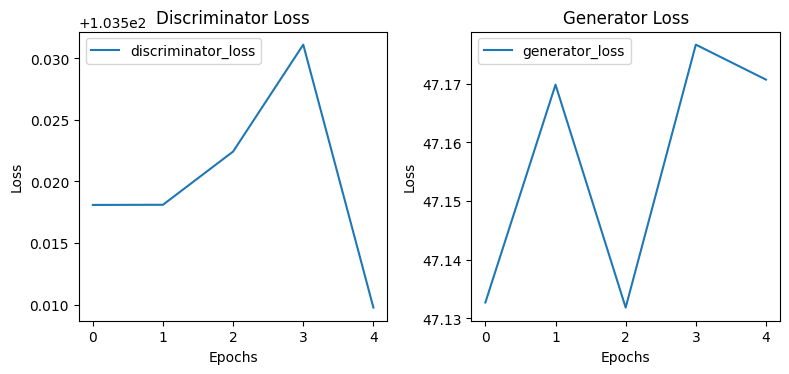

In [56]:
# Define the number of rows and columns for the subplots.
ROW = 1
COL = 2

# Create a figure with subplots and specify the figure size.
fig, axes = plt.subplots(ROW, COL, figsize=(8, 4))

# Plot DISCRIMINATOR_LOSS on the first subplot.
axes[0].plot(np.array(DISCRIMINATOR_LOSS), label='discriminator_loss')
axes[0].set_title('Discriminator Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot GENERATOR_LOSS on the second subplot.
axes[1].plot(np.array(GENERATOR_LOSS), label='generator_loss')
axes[1].set_title('Generator Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout to prevent overlapping of titles and labels.
plt.tight_layout()

# Show the subplots.
plt.show()


In [22]:
#To be continued...